In [11]:
import math
import numpy as np
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
plt.rc("figure", figsize=(12,6))

In [79]:
X, y = make_classification(n_samples=1000, n_features=10)
np.unique(y, return_counts=True)

(array([0, 1]), array([500, 500]))

## Vanilla Python

In [248]:
def py_accuracy(y_pred, y):
    size = len(y)
    result = 0
    for i in range(size):
        result += round(y_pred[i]) == y[i]
    return result / size
    
def py_dot_product(vec1, vec2):
    size = len(vec1)
    result = [0] * size
    for i in range(size):
        result[i] = vec1[i] * vec2[i]
    return sum(result)
    
    
def py_sigmoid(x):
    return 1 / (1 + math.e**-x)

def py_forward(w, X):
    size = len(X)
    predict = [0] * size
    for i in range(size):
        dot = py_dot_product(X[i], w)
        predict[i] = py_sigmoid(dot)
    return predict

def py_loss(predict, y):
    size = len(y)
    result = 0
    for i in range(size):
        p_1 = - y[i] * math.log(predict[i])
        p_0 = -(1 - y[i]) * math.log(1 - predict[i])
        result += p_0 + p_1
    return result / size

# Jacobian is the same
def py_grad(predict, X, y):
    size = len(y)
    column_size = len(X[0])
    grad = [0] * column_size
    for i in range(size):
        vals = [0] * column_size
        for j in range(column_size):
            grad[j] += (predict[i] - y[i]) * X[i][j]
    return grad

def py_update_params(w, grad, lr):
    return [w[i] - lr * grad[i] for i in range(len(w))]

In [249]:
py_X = np.insert(X, 0, 1, axis=1).tolist()
py_y = y.tolist()
py_w = [0]*len(py_X[0])

In [250]:
n_iter = 100
history = [0] * n_iter
accuracy = [0] * n_iter
for i in range(n_iter):
    pred = py_forward(py_w, py_X)
    history[i] = py_loss(pred, py_y)
    accuracy[i] = py_accuracy(pred, py_y)
    grad = py_grad(pred, py_X, py_y)
    py_w = py_update_params(py_w, grad, 0.001)

print("Accuracy:", accuracy[-1])

Accuracy: 0.863


In [251]:
py_w

[0.07774924569660538,
 -0.6774254288894237,
 0.009479832767762507,
 0.1540723056414814,
 0.07550578467204468,
 1.622369676770912,
 -0.03563948167345309,
 -0.06756975400462847,
 0.8191238366508318,
 -0.5795328014465245,
 -0.06753504733290507]

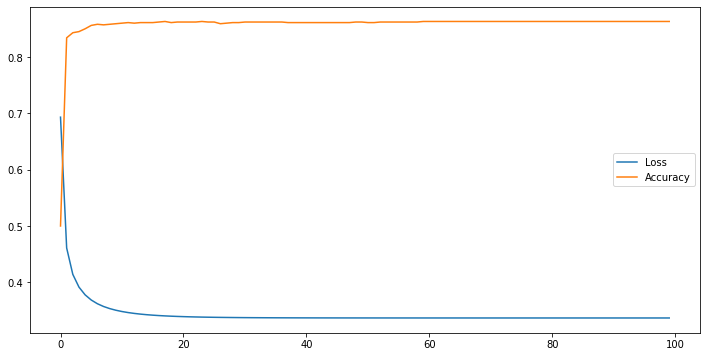

In [252]:
plt.plot(history)
plt.plot(accuracy)
plt.legend(["Loss", "Accuracy"])
plt.show()

## Numpy

In [253]:
def np_accuracy(y_pred, y):
    return np.mean(np.round(y_pred) == y)
        
def np_sigmoid(x):
    return 1 / (1 + np.exp(-x))

def np_forward(w, X):
    return np_sigmoid(X.dot(w))

def np_loss(y_pred, y):
    p_1 = -y * np.log(y_pred)
    p_0 = -(1 - y) * np.log(1 - y_pred)
    return np.mean(p_0 + p_1)

# Same Jacobian
def np_grad(y_pred, X, y):
    column_size = X.shape[1]
    grad = np.empty(column_size)
    for i in range(column_size):
        grad[i] = np.sum((y_pred - y) * X[:, i])
    return grad

# Pass by reference
def np_update_params(w, grad, lr):
    w -= lr * grad

In [254]:
np_X = np.insert(X, 0, 1, axis=1)
np_y = y
np_w = np.zeros(np_X.shape[1])

In [255]:
n_iter = 100
history = np.empty(n_iter)
accuracy = [0] * n_iter
for i in range(n_iter):
    pred = np_forward(np_w, np_X)
    history[i] = np_loss(pred, np_y)
    accuracy[i] = np_accuracy(pred, py_y)
    grad = np_grad(pred, np_X, np_y)
    np_update_params(np_w, grad, 0.001)

print("Accuracy:", accuracy[-1])

Accuracy: 0.863


In [257]:
np_w

array([ 0.07774925, -0.67742543,  0.00947983,  0.15407231,  0.07550578,
        1.62236968, -0.03563948, -0.06756975,  0.81912384, -0.5795328 ,
       -0.06753505])

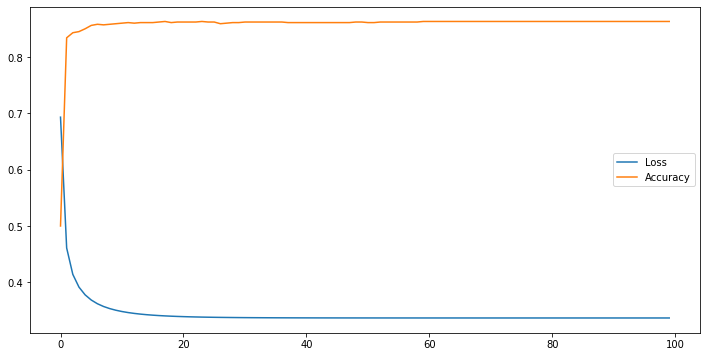

In [258]:
plt.plot(history)
plt.plot(accuracy)
plt.legend(["Loss", "Accuracy"])
plt.show()

## Jax

In [259]:
import jax
from jax import jit
from jax import grad as jgrad
from jax import numpy as jnp

# Setting device to cpu
jax.config.update('jax_platform_name', 'cpu')

In [264]:
@jit
def jax_accuracy(y_pred, y):
    return jnp.mean(jnp.round(y_pred) == y)

@jit
def jax_sigmoid(x):
    return 1 / (1 + jnp.exp(-x))

@jit
def jax_forward(w, X):
    return jax_sigmoid(X.dot(w))

@jit
def jax_loss(w, X, y):
    y_pred = jax_forward(w, X)
    p_1 = -y * jnp.log(y_pred) 
    p_0 = -(1 - y) * jnp.log(1 - y_pred) 
    return jnp.mean(p_0 + p_1)

jax_grad = jit(jgrad(jax_loss))

@jit
def jax_update_params(w, grad, lr):
    # Jax does not allow side effects
    # So have to return a new array
    return w - grad * lr

In [312]:
# Jax have not implemented insertion yet
# and I do not think it will because of
# its functional and immutable arrays

jax_X = jnp.array(np.insert(X, 0, 1, axis=1))
jax_y = jnp.array(y)
jax_w = jnp.zeros(jax_X.shape[1])

In [313]:
n_iter = 100
history = jnp.empty(n_iter)
accuracy = jnp.empty(n_iter)
lr = jnp.array(1.)
for i in range(n_iter):
    pred = jax_forward(jax_w, jax_X)
    loss = jax_loss(jax_w, jax_X, jax_y)
    acc = jax_accuracy(pred, jax_y)
    history = jax.ops.index_update(history, i, loss)
    accuracy = jax.ops.index_update(accuracy, i, acc)
    grad = jax_grad(jax_w, jax_X, jax_y)

    # For me gradients were 1000 times smaller than numpy
    # for this reason I choose learning rate = 1
    jax_w = jax_update_params(jax_w, grad, lr)
    
print("Accuracy:", acc)

Accuracy: 0.86300004


In [314]:
jax_w

DeviceArray([ 0.07774924, -0.67742544,  0.00947983,  0.15407228,
              0.0755058 ,  1.6223695 , -0.03563949, -0.06756974,
              0.819124  , -0.5795329 , -0.06753504], dtype=float32)

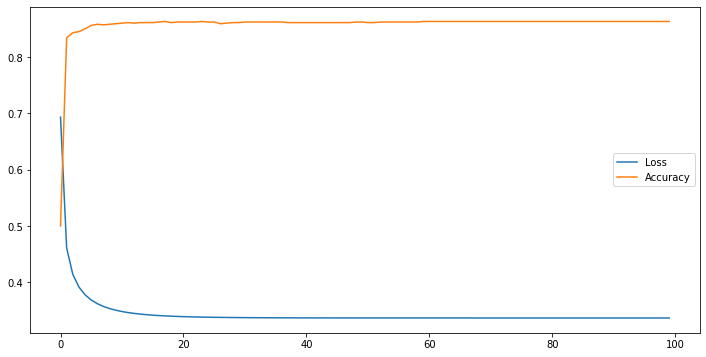

In [315]:
plt.plot(history)
plt.plot(accuracy)
plt.legend(["Loss", "Accuracy"])
plt.show()

## MxNet

In [358]:
import mxnet as mx

In [366]:
def mx_accuracy(y_pred, y):
    return mx.nd.mean(mx.nd.round(y_pred) == y)

def mx_sigmoid(x):
    return 1 / (1 + mx.nd.exp(-x))

def mx_forward(w, X):
    return mx_sigmoid(mx.nd.dot(mx_X, mx_w))

def mx_loss(y_pred, y):
    p_1 = -y * mx.nd.log(y_pred)
    p_0 = -(1 - y) * mx.nd.log(1 - y_pred)
    return mx.nd.mean(p_0 + p_1)

def mx_update_params(w, grad, lr):
    return w - lr * grad

In [373]:
# Mx already uses numpy inserting
# so I used numpy 
mx_X = mx.nd.array(np.insert(X, 0, 1, axis=1))
mx_y = mx.nd.array(y)
mx_w = mx.nd.zeros((mx_X.shape[1]))

In [374]:
n_iter = 10
history = mx.nd.empty(n_iter)
accuracy = mx.nd.empty(n_iter)
for i in range(n_iter):
    mx_w.attach_grad()
    with mx.autograd.record():
        pred = mx_forward(mx_w, mx_X)
        loss = mx_loss(pred, mx_y)
    history[i] = loss.asscalar()
    accuracy[i] = mx_accuracy(pred, mx_y).asscalar()
    loss.backward()
    
    # Same as jax gradients were 1000 times smaller than numpy
    # for this reason I choose learning rate = 1
    mx_w = mx_update_params(mx_w, mx_w.grad, 1)
    
print("Accuracy:", accuracy[-1].asscalar())

Accuracy: 0.859


In [375]:
mx_w.asnumpy()

array([ 0.01672599, -0.37362912,  0.01980077,  0.10078969,  0.03659893,
        1.2197562 , -0.00653823, -0.04595228,  0.5995904 , -0.46589705,
       -0.03306237], dtype=float32)

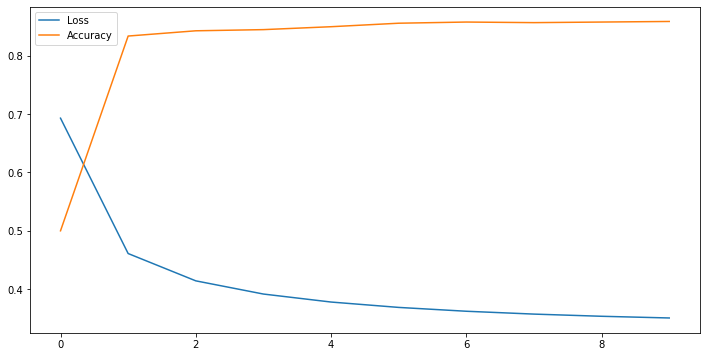

In [376]:
plt.plot(history.asnumpy())
plt.plot(accuracy.asnumpy())
plt.legend(["Loss", "Accuracy"])
plt.show()